Тонкая настройка нейронных моделей на корпусе лингвистической приемлемости подразумевает эксплицитное указание на приемлемость и неприемлемость предложений с помощью бинарной разметки. Однако можно проверить, способны ли нейронные сети определять приемлемость без дообучения на размеченных данных. Для этого используются вероятностные метрики.

## Приемлемость и вероятность

Приемлемость предложения — это степень, в которой предложение кажется естественным носителям языка. В лингвистике они используются для проверки грамматических теорий.

Компьютерная обработка языка традиционно больше интересовалась вероятностью предложений. Языковые модели оценивают вероятность встретить предложение $S$  — последовательность слов $(w_1,\cdots ,w_n)$. Вероятность предложения можно определить как произведение вероятности каждого слова с учетом предыдущих слов:
$$P(w_1,w_2, \dots, w_n) = p(w_1)p(w_2|w_1)p(w_3|w_1,w_2)\dots p(w_n|w_1,w_2,\dots,w_{n-1})= \prod\limits_{i = 1}^n p(w_i|w_1, \dots, w_{i-1})$$
Для каждого слова последовательности предсказывается вероятность встретить его в тексте при условии, что известно предыдущее слово: $w_2$ при условии $w_1$, $w_3$ при условии $w_1$ и $w_2$, и т.д.

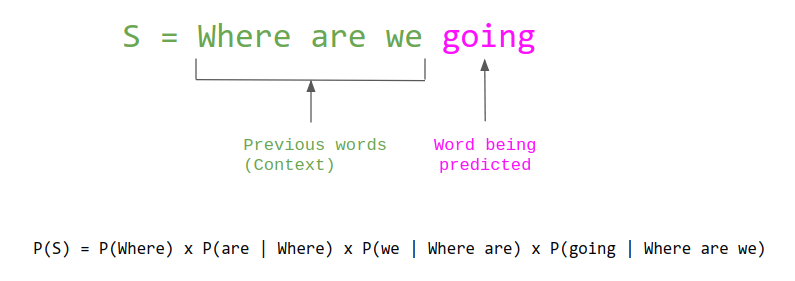

Связаны ли эти понятия: приемлемость и вероятность? И если да, то каким образом?

Впервые этот вопрос был исследован в следующей работе:

[Lau J. H., Clark A., Lappin S. (2017) Grammaticality, Acceptability, and Probability: A Probabilistic View of Linguistic Knowledge.](https://onlinelibrary.wiley.com/doi/full/10.1111/cogs.12414)

Исследователи экспериментировали с языковыми моделями, которые обучались предсказывать вероятность предложения на неразмеченных текстах. Однако вероятность появления языкового выражения в корпусе нельзя сравнивать с приемлемостью напрямую. Были разработаны специальные метрики, учитывающие длину предложения и лексическую частотность — параметры, которые зависят от состава
конкретного корпуса. В результате между оценками приемлемости и вероятностными метриками была обнаружена положительная корреляция (значение коэффициента корреляции Пирсона больше нуля).

Одна из таких метрик — PenLP — логарифмическая вероятность предложения, нормализованная по длине с учетом коэффициента масштабирования.

$$PenLP = \frac {logP(s)}{((5+|s|)/(5+1))^α}$$

$P(s)$ — вероятность предложения $s$

$|s|$ — длина предложения $s$

$α$ — коэффициент масштабирования

📌 Запишите функцию `pen_lp`, которая принимает на вход длину предложения (`text_len`) и его логарифмическую вероятность (`lp`), а возвращает значение метрики PenLP.

In [1]:
def pen_lp(text_len, lp):
  # Место для вашего кода
  penalty = ((5+text_len) / (5+1))**0.8
  return lp / penalty

## Вероятность предложения для энкодерных моделей

Ранее мы рассматривали автоэнкодерные языковые модели, которые позволяют получить векторное представление для каждого токена и для всего предложения. Они обучаются с помощью маскированного языкового моделирования: предсказывают вероятность токена на месте `[MASK]` с учетом левого и правого контекста одновременно.

Для таких моделей вероятность всего предложения также считается как произведение вероятностей всех слов. Однако вероятность каждого слова зависит не только от предыдущих, но и от следующих слов.

$$ \overleftrightarrow P (s)=\prod^{|s|}_{i=0}P(w_i|w_{<i},w_{>i})$$

В *n*-граммных моделях вероятность рассчитывается на основе частоты встречаемости слов в корпусе текстов. Для получения вероятности токена в энкодерных моделях необходимо заменить его на спецтокен `[MASK]`.

Попробуем определить вероятность каждого токена и вероятность всего предложения с помощью англоязычной модели BERT.

In [2]:
!pip install transformers -q

In [3]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
from transformers import AutoTokenizer, BertForMaskedLM

bidirectional = 'bert-base-cased'
bert_model = BertForMaskedLM.from_pretrained(bidirectional).to(device)
bert_tokenizer = AutoTokenizer.from_pretrained(bidirectional)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Вначале необходимо токенизировать предложение.

In [5]:
bert_tokenizer("I love you")

{'input_ids': [101, 146, 1567, 1128, 102], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}

Для подсчета вероятности нам понадобятся только индексы токенов.

📌 Запишите индексы токенов в переменную `input_indexes`

In [6]:
input_indexes = bert_tokenizer("I love you")['input_ids'] # Место для вашего кода
input_indexes

[101, 146, 7871, 1128, 102]

📌 Почему при токенизации изменилось количество токенов? Проверьте это с помощью метода для преобразования индексов обратно в токены (`bert_tokenizer.convert_ids_to_tokens()`)

In [7]:
# Место для вашего кода
bert_tokenizer.convert_ids_to_tokens(input_indexes)

['[CLS]', 'I', 'loves', 'you', '[SEP]']

📌 Запишите длину предложения без спецтокенов в переменную `text_len`.

In [8]:
text_len = len(input_indexes) - 2 # Место для вашего кода
text_len

3

Чтобы определить вероятность токена, необходимо заменить его индекс на индекс спецтокена `[MASK]`. Полученный список нужно преобразовать в pytorch тензор.

In [9]:
masked_index = 1
tokenize_masked = input_indexes.copy()
tokenize_masked[masked_index] = bert_tokenizer.convert_tokens_to_ids('[MASK]')
tokenize_masked = torch.tensor(tokenize_masked, device=device).unsqueeze(dim=0)
tokenize_masked

tensor([[ 101,  103, 7871, 1128,  102]], device='cuda:0')

К получившейсяся последовательности применим модель.

In [10]:
with torch.no_grad():
    output = bert_model(tokenize_masked)
output

MaskedLMOutput(loss=None, logits=tensor([[[ -7.0966,  -6.9703,  -7.1202,  ...,  -5.7988,  -5.7223,  -6.0632],
         [ -5.7047,  -5.9168,  -5.9492,  ...,  -4.6282,  -5.1526,  -4.5613],
         [ -9.7444,  -9.7267,  -9.0070,  ...,  -6.5232,  -7.1574,  -6.9686],
         [-10.2090, -10.1561, -10.5803,  ...,  -7.2013,  -8.3428,  -8.1977],
         [-12.9265, -13.7615, -13.1833,  ..., -10.4058, -12.0148, -11.5727]]],
       device='cuda:0'), hidden_states=None, attentions=None)

Нас интересуют логиты — ненормализованные выходы модели для каждого токена. Каждая строка соответствует токену в исходном предложении, каждый столбец — конкретному индексу в словаре. Логиты показывают, насколько вероятным на месте каждого токена в предложении является какой-либо другой токен из словаря.

In [11]:
logits = output[0]
logits, logits.shape

(tensor([[[ -7.0966,  -6.9703,  -7.1202,  ...,  -5.7988,  -5.7223,  -6.0632],
          [ -5.7047,  -5.9168,  -5.9492,  ...,  -4.6282,  -5.1526,  -4.5613],
          [ -9.7444,  -9.7267,  -9.0070,  ...,  -6.5232,  -7.1574,  -6.9686],
          [-10.2090, -10.1561, -10.5803,  ...,  -7.2013,  -8.3428,  -8.1977],
          [-12.9265, -13.7615, -13.1833,  ..., -10.4058, -12.0148, -11.5727]]],
        device='cuda:0'),
 torch.Size([1, 5, 28996]))

Запишем в отдельную переменную предсказания для токена, который заменен на маску.

In [12]:
predicted_score = logits[0, masked_index, :]
predicted_score, predicted_score.shape

(tensor([-5.7047, -5.9168, -5.9492,  ..., -4.6282, -5.1526, -4.5613],
        device='cuda:0'),
 torch.Size([28996]))

Применим функцию softmax, чтобы полученные вероятности в сумме давали единицу.

In [13]:
from torch.nn.functional import softmax
predicted_prob = softmax(predicted_score, dim=0)
predicted_prob, predicted_prob.sum()

(tensor([9.4390e-09, 7.6353e-09, 7.3912e-09,  ..., 2.7697e-08, 1.6394e-08,
         2.9613e-08], device='cuda:0'),
 tensor(1., device='cuda:0'))

Для определения вероятности слова, которое было заменено на спецтокен `[MASK]`, необходимо получить его вероятность по индексу и логарифмировать.

In [14]:
torch.log(predicted_prob[input_indexes[masked_index]])

tensor(-6.7201, device='cuda:0')

Чтобы посчитать вероятность каждого токена, нужно каждый токен заменить на маску.

Создадим тензор, где количество строк равно количеству токенов исходного предложения, количество столбцов равно количество токенов после токенизации.

На спецтокен `[MASK]` будем заменять только неслужебные токены (исходное предложение).

Получим тензор, где каждая строка содержит последовательность индексов исходного предложения с маской на месте различных токенов.

In [15]:
tokens_tensor = torch.zeros(text_len, len(input_indexes), dtype=torch.int32, device=device)

for i in range(text_len):
    masked_index = i + 1
    tokens_tensor[i, :] = torch.tensor(input_indexes.copy(), device=device)
    tokens_tensor[i, masked_index] = bert_tokenizer.convert_tokens_to_ids('[MASK]')
tokens_tensor

tensor([[ 101,  103, 7871, 1128,  102],
        [ 101,  146,  103, 1128,  102],
        [ 101,  146, 7871,  103,  102]], device='cuda:0', dtype=torch.int32)

📌 Примените модель к получившемуся тензору и запишите логиты в отдельную переменную.

In [16]:
# Место для вашего кода
with torch.no_grad():
    logits = bert_model(tokens_tensor)[0]
logits, logits.shape

(tensor([[[ -7.0966,  -6.9703,  -7.1202,  ...,  -5.7988,  -5.7223,  -6.0632],
          [ -5.7047,  -5.9168,  -5.9492,  ...,  -4.6282,  -5.1526,  -4.5613],
          [ -9.7444,  -9.7267,  -9.0070,  ...,  -6.5233,  -7.1574,  -6.9686],
          [-10.2090, -10.1561, -10.5803,  ...,  -7.2013,  -8.3428,  -8.1977],
          [-12.9265, -13.7615, -13.1833,  ..., -10.4058, -12.0148, -11.5727]],
 
         [[ -7.3251,  -7.2504,  -7.3616,  ...,  -6.0647,  -5.9599,  -6.2421],
          [ -8.0318,  -8.2555,  -8.0413,  ...,  -6.6397,  -6.4989,  -6.8840],
          [ -4.8762,  -4.3949,  -4.7477,  ...,  -3.5547,  -3.2921,  -2.3934],
          [ -9.2705,  -9.4107,  -9.3889,  ...,  -6.9679,  -7.3334,  -6.5045],
          [-15.2408, -16.5723, -15.4601,  ..., -12.5682, -13.6583, -12.6758]],
 
         [[ -7.4172,  -7.3704,  -7.4590,  ...,  -6.2119,  -6.0171,  -6.3690],
          [ -7.9719,  -8.1881,  -7.9563,  ...,  -6.5216,  -6.4315,  -6.7825],
          [ -7.0882,  -7.1541,  -6.6683,  ...,  -4.9244,  

Поскольку мы считаем логарифмическую вероятность каждого токена, вероятность всего предложения будет равна их сумме, а не произведению. Осуществим подсчет в цикле. Для каждого токена нужное распределение вероятностей определяется как $i$-й тензор — та последовательность индексов, где он был заменен на спецтокен `[MASK]`. В этом тензоре требуется найти строку, соответствующую нужному индексу — самой маске.

In [17]:
lp = 0.0
for i in range(text_len):
    masked_index = i + 1
    predicted_score = logits[i, masked_index, :]
    predicted_prob = softmax(predicted_score, dim=0)
    lp += torch.log(predicted_prob[input_indexes[masked_index]])
lp.item()

-16.9345760345459

📌 Для полученной логарифмической вероятности предложения посчитайте метрику PenLP.

In [18]:
# Место для вашего кода
pen_lp(text_len, lp.item())

-13.453130005383654

📌 Объедините все этапы для получения метрики PenLP в одну функцию `bert_pen_lp`.

In [19]:
def bert_pen_lp(input_indexes, tokenizer, model):
    # Место для вашего кода
    text_len = len(input_indexes) - 2
    tokens_tensor = torch.zeros(text_len, len(input_indexes), dtype=torch.int32, device=device)

    for i in range(text_len):
        masked_index = i + 1
        tokens_tensor[i, :] = torch.tensor(input_indexes.copy(), device=device)
        tokens_tensor[i, masked_index] = bert_tokenizer.convert_tokens_to_ids('[MASK]')

    with torch.no_grad():
        logits = bert_model(tokens_tensor)[0]

    lp = 0.0
    for i in range(text_len):
        masked_index = i + 1
        predicted_score = logits[i, masked_index, :]
        predicted_prob = softmax(predicted_score, dim=0)
        lp += torch.log(predicted_prob[input_indexes[masked_index]])

    return {'pen_lp': pen_lp(text_len, lp.item())}

Посчитаем метрику для грамматичного и неграмматичного предложения.

In [20]:
tokenized_sentence = bert_tokenizer("I love you")['input_ids']
bert_pen_lp(tokenized_sentence,
            bert_tokenizer,
            bert_model)

{'pen_lp': -2.3279113139490115}

In [21]:
tokenized_sentence = bert_tokenizer("I loves you")['input_ids']
bert_pen_lp(tokenized_sentence,
            bert_tokenizer,
            bert_model)

{'pen_lp': -13.453130005383654}

## Определение приемлемости без дообучения для CoLA

Полученные значения вероятности можно использовать для задачи оценки приемлемости. Проверим, какое качество модель BERT продемонстрирует при определении приемлемости для предложений из CoLA без тонкой настройки.

Корпус лингвистической приемлемости содержит предложения с бинарной разметкой по приемлемости: 1 — приемлемо, 0	— неприемлемо. Чтобы привести вероятностные метрики PenLP к бинарной шкале, необходимо найти пороговое значение (threshold), по которому будет проводиться разграничение. Если PenLP больше порогового значения, предложению присваивается метка 1. Если PenLP меньше порогового значения, предложению присваивается метка 0.

In [22]:
!pip install datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [23]:
from datasets import load_dataset
cola = load_dataset("glue", "cola")

README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/251k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/37.6k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/37.7k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8551 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1043 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1063 [00:00<?, ? examples/s]

В первую очередь избавимся от тестовой выборки, которая не содержит меток приемлемости.

Подбор порогового значения будем осуществлять на обучающей выборке. Разделим ее на две части в соотношении 9:1.

Измерение качества будет проходить на материале валидационной выборки.

In [24]:
cola.pop("test")
cola["train"] = cola["train"].train_test_split(test_size=0.1)
cola

DatasetDict({
    train: DatasetDict({
        train: Dataset({
            features: ['sentence', 'label', 'idx'],
            num_rows: 7695
        })
        test: Dataset({
            features: ['sentence', 'label', 'idx'],
            num_rows: 856
        })
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1043
    })
})

In [25]:
cola_train = cola["train"]
cola_val = cola["validation"]

In [26]:
cola_train

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 7695
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 856
    })
})

In [27]:
cola_val

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 1043
})

Осуществим токенизацию обучающей выборки.

In [28]:
cola_train = cola_train.map(lambda x: bert_tokenizer(x['sentence'], truncation=True), batched=True)

Map:   0%|          | 0/7695 [00:00<?, ? examples/s]

Map:   0%|          | 0/856 [00:00<?, ? examples/s]

In [29]:
cola_train

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7695
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 856
    })
})

📌 С помощью метода `map` добавьте к обучающему датасету столбец, который будет содержать метрики PenLP модели BERT для каждого предложения.

In [30]:
# Место для вашего кода
cola_train = cola_train.map(lambda x: bert_pen_lp(x["input_ids"],
                                                  bert_tokenizer,
                                                  bert_model))

Map:   0%|          | 0/7695 [00:00<?, ? examples/s]

Map:   0%|          | 0/856 [00:00<?, ? examples/s]

In [31]:
cola_train

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask', 'pen_lp'],
        num_rows: 7695
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask', 'pen_lp'],
        num_rows: 856
    })
})

Мы разделили обучающую выборку на две подвыборки: обучающую (`cola_train["train"]`) и тестовую (`cola_train["test"]`). Подбор пороговых значений будем осуществлять на обучающей подвыборке. Затем на тестовой определим финальное пороговое значение.

К обучающей подвыборке применим метод кросс-валидации (перекрестной проверки):
 - Зафиксируем некоторое целое число $k$, меньшее числа объектов в датасете.
 - Разобьем датасет на $k$ одинаковых частей.
 - Осуществим $k$ итераций, во время каждой из которых одна часть выступает в роли тестового множества, а объединение остальных — в роли обучающего.

Создадим словарь `kfold_index`, куда запишем индексы для разделения на обучение и тест при перекрестной проверке.

In [32]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, random_state=0, shuffle=True)

kfold_index = {}
for i, (train_index, test_index) in enumerate(kf.split(cola_train["train"]["pen_lp"])):
    print(f"Fold {i}:")
    print(f"  Train: shape={train_index.shape}")
    print(f"  Test:  shape={test_index.shape}")
    kfold_index[i] = [train_index, test_index]

Fold 0:
  Train: shape=(6925,)
  Test:  shape=(770,)
Fold 1:
  Train: shape=(6925,)
  Test:  shape=(770,)
Fold 2:
  Train: shape=(6925,)
  Test:  shape=(770,)
Fold 3:
  Train: shape=(6925,)
  Test:  shape=(770,)
Fold 4:
  Train: shape=(6925,)
  Test:  shape=(770,)
Fold 5:
  Train: shape=(6926,)
  Test:  shape=(769,)
Fold 6:
  Train: shape=(6926,)
  Test:  shape=(769,)
Fold 7:
  Train: shape=(6926,)
  Test:  shape=(769,)
Fold 8:
  Train: shape=(6926,)
  Test:  shape=(769,)
Fold 9:
  Train: shape=(6926,)
  Test:  shape=(769,)


Создадим функцию `split_data_values`, которая возвращает `n` значений для разбиения массива данных `data` на равные части:
- Каждое обучающее множество, полученое при кросс-валидации, разделим на `n+2` примерно равных частей.
- Определим `n` границ разбиения — среднее значение между последним элементом `i`-й части и первым элементом `i+1`-й части.
- Эти значения будем использовать в качестве потенциальных пороговых значений для классификации.

In [36]:
import numpy as np

def split_data_values(data, n):
    split_data = np.array_split(np.sort(data), n+2)
    split_values = [(split_data[i][-1] + split_data[i+1][0])/2 for i in range(len(split_data)-2)]
    return split_values

Создадим функцию `select_best_threshold` (принимает на вход датасет и потенциальные пороговые значения):
- в цикле для каждого порогового значения
  - записываем бинарные предсказания
  - считаем значение коэффициента корреляции Мэтьюса
- среди всех значений MCC выбираем максимальное, определяем его индекс и записываем пороговое значение, полученное по этому индексу

In [38]:
from sklearn.metrics import matthews_corrcoef

def select_best_threshold(dataset, thresholds):
    mcc = []
    for t in thresholds:
      preds = [1 if x > t else 0 for x in dataset["pen_lp"]]
      mcc.append(matthews_corrcoef(dataset['label'], preds))
    best_threshold = thresholds[mcc.index(max(mcc))]
    return best_threshold

Применяем оба этапа к обучающей подвыборке (`cola_train["train"]`). В цикле для каждого разбиения из кросс-валидации:
- определяем по индексам текущие обучающее и тестовое множества (`kfold_index`)
- для обучающего множества находим `n` значений для разбиения на равные части (`split_data_values`)
- на материале тестового множества выбираем одно лучшее пороговое значение (`select_best_threshold`)

In [39]:
kfold_thresholds = []
for i, (train_index, test_index) in enumerate(kf.split(cola_train["train"]["pen_lp"])):
    kfold_train = cola_train["train"].select(kfold_index[i][0])
    kfold_test = cola_train["train"].select(kfold_index[i][1])
    split_values_train = split_data_values(kfold_train["pen_lp"], 100)
    selected_value_test = select_best_threshold(kfold_test, split_values_train)
    kfold_thresholds.append(selected_value_test)

In [40]:
kfold_thresholds

[-14.453764100149467,
 -18.295019900631825,
 -14.910090249029343,
 -15.215379759026249,
 -12.964960016359115,
 -13.45496297619633,
 -15.819429169901895,
 -15.345527992305708,
 -13.606878431863969,
 -13.559223168602298]

С помощью той же функции `select_best_threshold` находим финальное пороговое значение на материале тестовой подвыборки обучающей выборки (`cola_train["test"]`).

In [41]:
final_threshold = select_best_threshold(cola_train["test"], kfold_thresholds)
final_threshold

-15.345527992305708

Токенизируем предложения и записываем значения метрики PenLP.

In [42]:
cola_val = cola_val.map(lambda x: bert_tokenizer(x['sentence'], truncation=True), batched=True)
cola_val = cola_val.map(lambda x: bert_pen_lp(x["input_ids"],
                                             bert_tokenizer,
                                             bert_model))

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

📌 Запишите предсказанные метки приемлемости на материале валидационной выборки и посчитайте значение коэффициента корреляции Мэтьюса.

In [43]:
# Место для вашего кода
val_preds = [1 if x > final_threshold else 0 for x in cola_val["pen_lp"]]
matthews_corrcoef(cola_val["label"], val_preds)

0.30678681453630063

Также можно посчитать значение accuracy.

In [44]:
from sklearn.metrics import accuracy_score
accuracy_score(cola_val["label"], val_preds)

0.7123681687440077